# Lab | Handling Data Imbalance in Classification Models
For this lab and in the next lessons we will build a model on customer churn binary classification problem. You will be using `files_for_lab/Customer-Churn.csv` file.

## Scenario
You are working as an analyst with this internet service provider. You are provided with this historical data about your company's customers and their churn trends. Your task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.

## Instructions
In this lab, we will first take a look at the degree of imbalance in the data and correct it using the techniques we learned on the class.

Here is the list of steps to be followed (building a simple model without balancing the data):

* Import the required libraries and modules that you would need.
* Read that data into Python and call the dataframe `churnData`.
* Check the datatypes of all the columns in the data. You would see that the column `TotalCharges` is object type. Convert this column into numeric type using `pd.to_numeric` function.
* Check for null values in the dataframe. Replace the null values.
* Use the following features: `tenure`, `SeniorCitizen`, `MonthlyCharges` and `TotalCharges`:
    * Scale the features either by using normalizer or a standard scaler.
    * Split the data into a training set and a test set.
    * Fit a logistic regression model on the training data.
    * Check the accuracy on the test data.

**Note:** So far we have not balanced the data.

Managing imbalance in the dataset

* Check for the imbalance.
* Use the resampling strategies used in class for upsampling and downsampling to create a balance between the two classes.
* Each time fit the model and see how the accuracy of the model is.

### Import the required libraries and modules that you would need.

In [74]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, r2_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix, mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import warnings
warnings.filterwarnings('ignore')

### Read that data into Python and call the dataframe `churnData`.

In [2]:
churnData = pd.read_csv('/Users/pauli/Desktop/Ironhack/Week17/Sabado/lab-handling-data-imbalance-classification/files_for_lab/Customer-Churn.csv')
churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


### Check the datatypes of all the columns in the data. You would see that the column TotalCharges is object type. Convert this column into numeric type using `pd.to_numeric` function.

In [3]:
churnData.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

In [4]:
# Converting this column into numeric type
churnData.TotalCharges = pd.to_numeric(churnData.TotalCharges, errors="coerce")
churnData.TotalCharges.dtypes

dtype('float64')

In [5]:
# Checking that the datatype conversion did not create any nulls
round(churnData.isna().sum()* 100 / churnData.shape[0], 2)

gender              0.00
SeniorCitizen       0.00
Partner             0.00
Dependents          0.00
tenure              0.00
PhoneService        0.00
OnlineSecurity      0.00
OnlineBackup        0.00
DeviceProtection    0.00
TechSupport         0.00
StreamingTV         0.00
StreamingMovies     0.00
Contract            0.00
MonthlyCharges      0.00
TotalCharges        0.16
Churn               0.00
dtype: float64

> Only the 0,16% of the data are null values, so I will remove them.

In [6]:
# Removing the null values
churnData.dropna(axis=0, inplace=True)

In [7]:
churnData.isnull().sum().sum()

0

In [8]:
churnData.shape

(7032, 16)

### Use the following features: `tenure`, `SeniorCitizen`, `MonthlyCharges` and `TotalCharges`:

In [9]:
def diff_function(data):
        categoricals = pd.DataFrame()
        continuous = pd.DataFrame()
        discretes = pd.DataFrame()
        for i in data:  
            if np.dtype(data[i]) == 'object':
                categoricals[i] = data[i]
            elif len(data[i].unique()) > 20 or np.dtype(data[i]) == 'float':  #(len(data[i].unique())*0.8):
                continuous[i] = data[i]
            else: 
                discretes[i] = data[i]
        return categoricals, continuous, discretes
    
categoricals, continuous, discretes = diff_function(churnData)

In [10]:
categoricals.columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'Churn'],
      dtype='object')

In [11]:
continuous.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [13]:
discretes.columns

Index(['SeniorCitizen'], dtype='object')

#### Scale the features either by using normalizer or a standard scaler.

In [38]:
# Scaling the 3 features that are continuous
transformer = MinMaxScaler()    # To normalize continuous features we apply the MinMaxScaler
x_norm = transformer.fit_transform(continuous)

continuous = pd.DataFrame(x_norm, columns=continuous.columns)
continuous

,tenure,MonthlyCharges,TotalCharges
0,0.000000,0.115423,0.001275
1,0.464789,0.385075,0.215867
2,0.014085,0.354229,0.010310
3,0.619718,0.239303,0.210241
4,0.014085,0.521891,0.015330
...,...,...,...
7027,0.323944,0.662189,0.227521
7028,1.000000,0.845274,0.847461
7029,0.140845,0.112935,0.037809
7030,0.042254,0.558706,0.033210


In [39]:
# Since SeniorCitizen is a Yes/No feature, we'll consider it a categorical value and encode it
discretes = pd.DataFrame(churnData["SeniorCitizen"])
discretes = pd.get_dummies(discretes, columns=discretes.columns, drop_first=True)
discretes

,SeniorCitizen_1
0,0
1,0
2,0
3,0
4,0
...,...
7038,0
7039,0
7040,0
7041,1


In [40]:
# Combining scaled numerical data and encoded categorical data
discretes.reset_index(drop=True, inplace=True)
continuous.reset_index(drop=True, inplace=True)

X = pd.concat([discretes, continuous], axis=1)
X.shape

(7032, 4)

In [33]:
y = churnData['Churn']
y.shape

(7032,)

#### Split the data into a training set and a test set.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Fit a logistic regression model on the training data.

In [45]:
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
predictions = model.predict(X_test)

#### Check the accuracy on the test data.

In [76]:
# Accuracy on the test data
model.score(X_test, y_test)

0.7834123222748816

              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1549
         Yes       0.63      0.44      0.52       561

    accuracy                           0.78      2110
   macro avg       0.73      0.67      0.69      2110
weighted avg       0.77      0.78      0.77      2110



<AxesSubplot:>

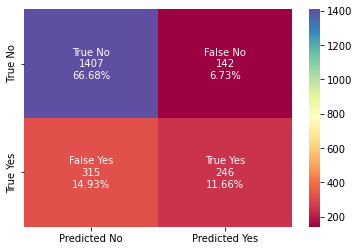

In [82]:
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test))

# Confusion Matrix on test set.
cm = confusion_matrix(y_test, pred_test)
group_names = ['True No', 'False No', 'False Yes', 'True Yes']

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', xticklabels=["Predicted No", "Predicted Yes"], yticklabels=[" True No", "True Yes"])


> The model is trained with a much higher number of `No` outcomes than `Yes`, and as such it predicts with very high accuracy the `No`.

### Managing imbalance in the dataset

#### Check for the imbalance.

In [52]:
round(y_train.value_counts()/len(y_train)*100, 2)

No     73.43
Yes    26.57
Name: Churn, dtype: float64

> The majority class with 73,43 % data points is `No`.

> The minority class with 26,57 % data points is `Yes`.

#### Use the resampling strategies used in class for upsampling and downsampling to create a balance between the two classes.
#### Each time fit the model and see how the accuracy of the model is.

**Synthetic Minority Oversampling TEchnique (SMOTE):** is an oversampling technique based on nearest neighbors that adds new points between existing points

In [85]:
# Apply oversampling to X_train and y_train
smote = SMOTE(k_neighbors = 3, random_state = 100)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train,y_train)

In [88]:
y_train.value_counts() 

No     3614
Yes    1308
Name: Churn, dtype: int64

In [87]:
# Here we can see that we create synthetic data.
y_train_SMOTE.value_counts()

Yes    3614
No     3614
Name: Churn, dtype: int64

In [90]:
model_SMOTE = LogisticRegression()
model_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)

LogisticRegression()

              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1549
         Yes       0.63      0.44      0.52       561

    accuracy                           0.78      2110
   macro avg       0.73      0.67      0.69      2110
weighted avg       0.77      0.78      0.77      2110



<AxesSubplot:>

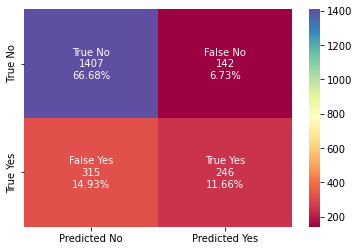

In [99]:
pred_test_SMOTE = model.predict(X_test)
print(classification_report(y_test, pred_test_SMOTE))

# Confusion Matrix on train set.
cm = confusion_matrix(y_test, pred_test_SMOTE)
group_names = ['True No', 'False No', 'False Yes', 'True Yes']

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', xticklabels=["Predicted No", "Predicted Yes"], yticklabels=[" True No", "True Yes"])


**Tomek Links** Undersampling

In [106]:
# Apply undersampling to X_train and y_train
TL = TomekLinks()
X_train_TL, y_train_TL = TL.fit_resample(X_train, y_train)

In [107]:
y_train.value_counts()  

No     3614
Yes    1308
Name: Churn, dtype: int64

In [108]:
# Here we can see that we create synthetic data.
y_train_TL.value_counts() 

No     3252
Yes    1308
Name: Churn, dtype: int64

In [109]:
model_TL = LogisticRegression()
model_TL.fit(X_train_TL, y_train_TL)

LogisticRegression()

              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1549
         Yes       0.63      0.44      0.52       561

    accuracy                           0.78      2110
   macro avg       0.73      0.67      0.69      2110
weighted avg       0.77      0.78      0.77      2110



<AxesSubplot:>

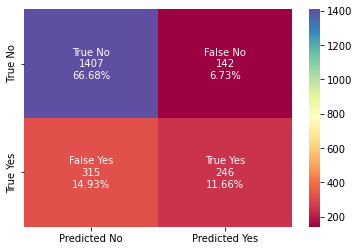

In [110]:
pred_test_TL = model.predict(X_test)
print(classification_report(y_test, pred_test_TL))

# Confusion Matrix on train set.
cm = confusion_matrix(y_test, pred_test_TL)
group_names = ['True No', 'False No', 'False Yes', 'True Yes']

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', xticklabels=["Predicted No", "Predicted Yes"], yticklabels=[" True No", "True Yes"])
